In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "T_CD8_Naive"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
COMBAT2022_L035_N00049_T0_GCTCTGTTCTACCAGA,COMBAT2022,COMBAT2022_L035,COMBAT2022_N00049_T0,5_GEX_V1,sepsis,male,71-80,T_CD8_Naive,T_CD8_Naive
COMBAT2022_L036_N00049_T0_AATCGGTTCCGAGCCA,COMBAT2022,COMBAT2022_L036,COMBAT2022_N00049_T0,5_GEX_V1,sepsis,male,71-80,T_CD8_Naive,T_CD8_Naive
COMBAT2022_L036_N00049_T0_CGCGTTTGTTATTCTC,COMBAT2022,COMBAT2022_L036,COMBAT2022_N00049_T0,5_GEX_V1,sepsis,male,71-80,T_CD8_Naive,T_CD8_Naive
COMBAT2022_L036_N00049_T0_TTTATGCCAACTGCTA,COMBAT2022,COMBAT2022_L036,COMBAT2022_N00049_T0,5_GEX_V1,sepsis,male,71-80,T_CD8_Naive,T_CD8_Naive
COMBAT2022_L037_N00049_T0_GAAACTCTCCGCAAGC,COMBAT2022,COMBAT2022_L037,COMBAT2022_N00049_T0,5_GEX_V1,sepsis,male,71-80,T_CD8_Naive,T_CD8_Naive
...,...,...,...,...,...,...,...,...,...
Terekhova2023_L076_E27_T0_TTGACTTTCTGCGGCA,Terekhova2023,Terekhova2023_L076,Terekhova2023_E27_T0,5_GEX_V2,healthy,male,61-70,T_CD8_Naive,T_CD8_Naive
Terekhova2023_L076_E27_T0_TTGCCGTAGTGTCCAT,Terekhova2023,Terekhova2023_L076,Terekhova2023_E27_T0,5_GEX_V2,healthy,male,61-70,T_CD8_Naive,T_CD8_Naive
Terekhova2023_L076_E27_T0_TTGGCAATCCCATTTA,Terekhova2023,Terekhova2023_L076,Terekhova2023_E27_T0,5_GEX_V2,healthy,male,61-70,T_CD8_Naive,T_CD8_Naive


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
2,0,3,0.520233,0.461874,0.240282
0,0,1,0.517905,0.470588,0.243720
1,0,2,0.516159,0.477124,0.246272
3,0,4,0.376500,1.000000,0.376500
13,4,1,0.883333,0.470588,0.415686
5,1,3,0.930563,0.461874,0.429803
8,2,3,0.947175,0.461874,0.437475
10,3,1,0.930563,0.470588,0.437912
11,3,2,0.947175,0.477124,0.451920
7,2,1,0.971855,0.470588,0.457343


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

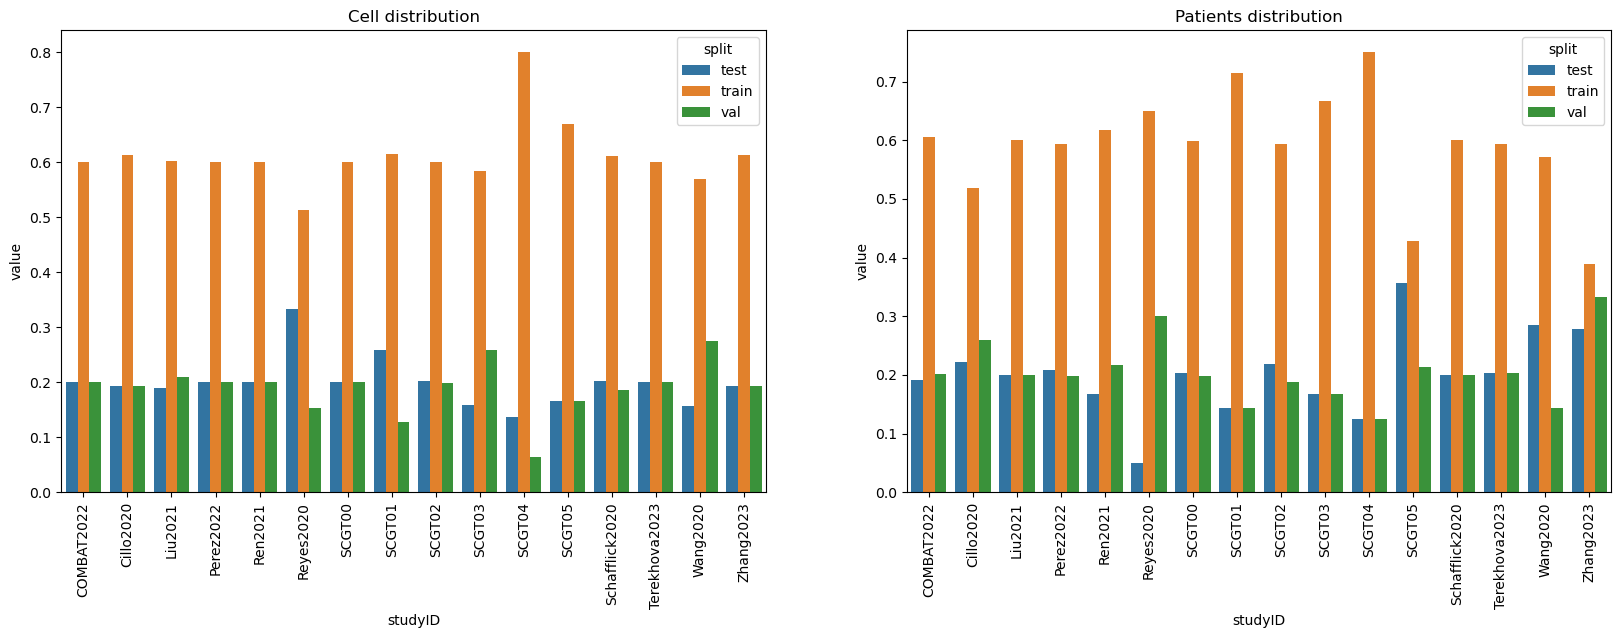

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((129095, 935), (42286, 935), (42395, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((129095,), (42286,), (42395,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-17 19:11:06,063] A new study created in memory with name: no-name-6dc8ca6e-f55d-4f88-9b38-2ce0010dc788


/tmp/ipykernel_1080144/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250317_191109-zzy7ppq5
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_T_CD8_Naive


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/zzy7ppq5


[I 2025-03-17 19:11:19,332] Trial 0 finished with value: -0.962716 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.962716.


[I 2025-03-17 19:11:26,736] Trial 1 finished with value: -0.972164 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.972164.


[I 2025-03-17 19:11:34,411] Trial 2 finished with value: -0.975384 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 2 with value: -0.975384.


[I 2025-03-17 19:11:41,570] Trial 3 finished with value: -0.961419 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 2 with value: -0.975384.


[I 2025-03-17 19:11:47,868] Trial 4 finished with value: -0.972535 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 2 with value: -0.975384.


[I 2025-03-17 19:11:51,446] Trial 5 pruned. Trial was pruned at iteration 3.


[I 2025-03-17 19:11:54,503] Trial 6 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:11:57,330] Trial 7 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:12:00,412] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:03,749] Trial 9 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:12:06,601] Trial 10 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:09,635] Trial 11 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:13,095] Trial 12 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:16,034] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:19,268] Trial 14 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:12:22,416] Trial 15 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:25,823] Trial 16 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:12:28,682] Trial 17 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:12:31,626] Trial 18 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:34,914] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:38,183] Trial 20 pruned. Trial was pruned at iteration 3.


[I 2025-03-17 19:12:41,141] Trial 21 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:44,546] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:12:52,777] Trial 23 finished with value: -0.983643 and parameters: {'max_depth': 4, 'min_child_weight': 32, 'subsample': 0.8583921597212885, 'colsample_bynode': 0.5037718685573817, 'learning_rate': 0.28709646695253643}. Best is trial 23 with value: -0.983643.


[I 2025-03-17 19:12:56,050] Trial 24 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:04,168] Trial 25 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 19:13:07,437] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:10,451] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:13,329] Trial 28 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:16,572] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:19,836] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:22,751] Trial 31 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:13:25,774] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:29,153] Trial 33 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:32,110] Trial 34 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:35,224] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:39,024] Trial 36 pruned. Trial was pruned at iteration 3.


[I 2025-03-17 19:13:42,417] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:45,318] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:48,469] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:51,654] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:54,770] Trial 41 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:13:57,722] Trial 42 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:14:00,980] Trial 43 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:14:04,152] Trial 44 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:14:07,153] Trial 45 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:14:10,471] Trial 46 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:14:13,681] Trial 47 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 19:14:16,634] Trial 48 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 19:14:22,854] Trial 49 finished with value: -0.979976 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.4315900208893261, 'colsample_bynode': 0.2695551141938907, 'learning_rate': 0.0061754496810483605}. Best is trial 23 with value: -0.983643.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_T_CD8_Naive_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:0.96090	validation_0-custom_f1_score:-0.95424


[1]	validation_0-mlogloss:0.69287	validation_0-custom_f1_score:-0.98179


[2]	validation_0-mlogloss:0.51887	validation_0-custom_f1_score:-0.98511


[3]	validation_0-mlogloss:0.40138	validation_0-custom_f1_score:-0.98564


[4]	validation_0-mlogloss:0.31094	validation_0-custom_f1_score:-0.98627


[5]	validation_0-mlogloss:0.24468	validation_0-custom_f1_score:-0.98636


[6]	validation_0-mlogloss:0.19580	validation_0-custom_f1_score:-0.98628


[7]	validation_0-mlogloss:0.15900	validation_0-custom_f1_score:-0.98589


[8]	validation_0-mlogloss:0.12916	validation_0-custom_f1_score:-0.98623


[9]	validation_0-mlogloss:0.10833	validation_0-custom_f1_score:-0.98560


[10]	validation_0-mlogloss:0.09330	validation_0-custom_f1_score:-0.98305


[11]	validation_0-mlogloss:0.08015	validation_0-custom_f1_score:-0.98307


[12]	validation_0-mlogloss:0.06943	validation_0-custom_f1_score:-0.98420


[13]	validation_0-mlogloss:0.06172	validation_0-custom_f1_score:-0.98328


[14]	validation_0-mlogloss:0.05468	validation_0-custom_f1_score:-0.98415


[15]	validation_0-mlogloss:0.04882	validation_0-custom_f1_score:-0.98575


[16]	validation_0-mlogloss:0.04376	validation_0-custom_f1_score:-0.98663


[17]	validation_0-mlogloss:0.04193	validation_0-custom_f1_score:-0.98623


[18]	validation_0-mlogloss:0.03856	validation_0-custom_f1_score:-0.98681


[19]	validation_0-mlogloss:0.03712	validation_0-custom_f1_score:-0.98693


[20]	validation_0-mlogloss:0.03487	validation_0-custom_f1_score:-0.98713


[21]	validation_0-mlogloss:0.03313	validation_0-custom_f1_score:-0.98756


[22]	validation_0-mlogloss:0.03292	validation_0-custom_f1_score:-0.98728


[23]	validation_0-mlogloss:0.03211	validation_0-custom_f1_score:-0.98746


[24]	validation_0-mlogloss:0.03165	validation_0-custom_f1_score:-0.98743


[25]	validation_0-mlogloss:0.03140	validation_0-custom_f1_score:-0.98738


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5037718685573817,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x708825f32340>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.28709646695253643, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=32, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=26, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_T_CD8_Naive_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[19:14:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


